<a href="https://colab.research.google.com/github/FariaParvinMegha/thesis_1/blob/main/CNN%2BBiLSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
pip install git+https://github.com/forrestbao/pyeeg.git

  Cloning https://github.com/forrestbao/pyeeg.git to /tmp/pip-req-build-psrx6hbf
  Running command git clone --filter=blob:none --quiet https://github.com/forrestbao/pyeeg.git /tmp/pip-req-build-psrx6hbf
  Resolved https://github.com/forrestbao/pyeeg.git to commit a6c18bb093e4748f9d9c208535a6ae024a0802b8
  Preparing metadata (setup.py) ... done
  Created wheel for pyeeg: filename=pyeeg-0.4.4-py2.py3-none-any.whl size=28111 sha256=1b9e382a04353f3ca16d96d6371db7d80f925b981d965a2a3fd1c442367c0629
  Stored in directory: /tmp/pip-ephem-wheel-cache-6b1orjx8/wheels/a8/c4/1a/cee09dcc12a11620066d35ace42e3c1e3bfbcc1db3a0ce7788
Successfully built pyeeg


In [ ]:
import numpy as np
import pyeeg as pe
import pickle as pickle
import pandas as pd
import math
from sklearn.preprocessing import normalize

import os
import time

In [ ]:
channel = [1,2,4,5,8,10,15,21,22,25,26,27,28,31,32]
band = [4,8,13,22,30,45] #5 bands
window_size = 256 #Averaging band power of 2 sec
step_size = 16 #Each 0.125 sec update once
sample_rate = 128 #Sampling rate of 128 Hz
subjectList = ['01','02','03','04','05','06','07','08','09','10','11','12','13','14','15','16','17','18','19','20','21','22','23','24','25','26','27','28','29','30','31','32']

In [ ]:
def FFT_Processing (sub, channel, band, window_size, step_size, sample_rate):
   meta = []
   with open('/content/drive/MyDrive/data_preprocessed_python/s' + sub + '.dat', 'rb') as file:

        subject = pickle.load(file, encoding='latin1') #resolve the python 2 data problem by encoding : latin1

        for i in range (0,40):
            # loop over 0-39 trails
            data = subject["data"][i]
            labels = subject["labels"][i]
            start = 0;
            #data.shape

            while start + window_size < data.shape[1]:
                meta_array = []
                meta_data = [] #meta vector for analysis
                for j in channel:
                    X = data[j][start : start + window_size] #Slice raw data over 2 sec, at interval of 0.125 sec
                    Y = pe.bin_power(X, band, sample_rate) #FFT over 2 sec of channel j, in seq of theta, alpha, low beta, high beta, gamma
                    meta_data = meta_data + list(Y[0])

                meta_array.append(np.array(meta_data))
                meta_array.append(labels)

                meta.append(np.array(meta_array))
                start = start + step_size

        meta = np.array(meta)
        np.save('/content/drive/MyDrive/processed_data/s' + sub, meta, allow_pickle=True, fix_imports=True)

In [ ]:
for subjects in subjectList:
    FFT_Processing (subjects, channel, band, window_size, step_size, sample_rate)

<ipython-input-7-f187518c58b2>:25: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  meta.append(np.array(meta_array))


In [ ]:
data_training = []
label_training = []
data_testing = []
label_testing = []

for subjects in subjectList:
  with open('/content/drive/MyDrive/processed_data/s' + subjects + '.npy', 'rb') as file:

      sub = np.load(file, allow_pickle=True)
      # sub = shuffle(sub, random_state=42)
      for i in range (0,sub.shape[0]):
      # print(sub.shape[0])
        if i % 8 == 0:
          # print(sub[i][0])
          data_testing.append(sub[i][0])
          label_testing.append(sub[i][1])
        else:
          data_training.append(sub[i][0])
          label_training.append(sub[i][1])


np.save('/content/drive/MyDrive/data_training/data_training', np.array(data_training), allow_pickle=True, fix_imports=True)
np.save('/content/drive/MyDrive/label_training/label_training', np.array(label_training), allow_pickle=True, fix_imports=True)
print("training dataset:", np.array(data_training).shape, np.array(label_training).shape)

np.save('/content/drive/MyDrive/data_testing/data_testing', np.array(data_testing), allow_pickle=True, fix_imports=True)
np.save('/content/drive/MyDrive/label_testing/label_testing', np.array(label_testing), allow_pickle=True, fix_imports=True)
print("testing dataset:", np.array(data_testing).shape, np.array(label_testing).shape)

training dataset: (546560, 75) (546560, 4)
testing dataset: (78080, 75) (78080, 4)


In [ ]:
import keras
import keras.backend as K
from keras.layers.convolutional import Conv1D
from keras.models import Sequential
from keras.utils import to_categorical
from keras.layers import Dense, Dropout, Flatten, MaxPooling2D
from keras.models import Model
import timeit
from keras.layers.convolutional import MaxPooling1D, ZeroPadding1D
from keras.optimizers import SGD
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [ ]:
with open('/content/drive/MyDrive/data_training/data_training.npy', 'rb') as fileTrain:
    X  = np.load(fileTrain)

with open('/content/drive/MyDrive/label_training/label_training.npy', 'rb') as fileTrainL:
    Y  = np.load(fileTrainL)


X = normalize(X)
Z = np.ravel(Y[:, [1]])

Arousal_Train = np.ravel(Y[:, [0]])
Valence_Train = np.ravel(Y[:, [1]])
Domain_Train = np.ravel(Y[:, [2]])
Like_Train = np.ravel(Y[:, [3]])

In [ ]:
from keras.utils import to_categorical
y_train = to_categorical(Z)
y_train

array([[0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [ ]:
x_train = np.array(X[:])
x_train

array([[0.07339435, 0.12075104, 0.13829485, ..., 0.1280565 , 0.07018148,
        0.1134959 ],
       [0.07885531, 0.12747992, 0.14919339, ..., 0.12730831, 0.07109168,
        0.11043889],
       [0.08533558, 0.13516844, 0.13988254, ..., 0.12415193, 0.08130252,
        0.11322193],
       ...,
       [0.09659814, 0.08755737, 0.0717007 , ..., 0.12654636, 0.07032577,
        0.1357002 ],
       [0.05419379, 0.04172611, 0.06316159, ..., 0.07651449, 0.07481333,
        0.15625307],
       [0.04212001, 0.03804705, 0.05101342, ..., 0.15677847, 0.08915938,
        0.1738975 ]])

In [ ]:
with open('/content/drive/MyDrive/data_testing/data_testing.npy', 'rb') as fileTest:
    M  = np.load(fileTest, allow_pickle=True)

with open('/content/drive/MyDrive/label_testing/label_testing.npy', 'rb') as fileTestL:
    N  = np.load(fileTestL, allow_pickle=True)


M = normalize(M)
L = np.ravel(N[:, [1]])

Arousal_Test = np.ravel(N[:, [0]])
Valence_Test = np.ravel(N[:, [1]])
Domain_Test = np.ravel(N[:, [2]])
Like_Test = np.ravel(N[:, [3]])

In [ ]:
x_test = np.array(M[:])
x_test

array([[0.07130639, 0.13004974, 0.14904098, ..., 0.13037493, 0.06915833,
        0.11329141],
       [0.07752854, 0.11159266, 0.15839351, ..., 0.12750984, 0.10384615,
        0.11456205],
       [0.12063984, 0.11458396, 0.15857479, ..., 0.16313861, 0.10613   ,
        0.09527421],
       ...,
       [0.10384991, 0.07610023, 0.05910766, ..., 0.12633775, 0.0613344 ,
        0.1300211 ],
       [0.16560993, 0.09638217, 0.07809719, ..., 0.09959634, 0.04863949,
        0.12221513],
       [0.13986119, 0.08034478, 0.07793579, ..., 0.11777917, 0.08359565,
        0.15629315]])

In [ ]:
y_test = to_categorical(L)
y_test

array([[0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.fit_transform(x_test)

In [ ]:
x_train = x_train.reshape(x_train.shape[0],x_train.shape[1], 1)
x_test = x_test.reshape(x_test.shape[0],x_test.shape[1], 1)
print(x_train.shape)
print(x_test.shape)

(546560, 75, 1)
(78080, 75, 1)


In [ ]:
print(y_train.shape)
print(y_test.shape)

(546560, 10)
(78080, 10)


In [ ]:
batch_size = 256
num_classes = 10
epochs = 50
input_shape=(x_train.shape[1], 1)
print(input_shape)


(75, 1)


In [ ]:
from keras.layers import Convolution1D, ZeroPadding1D, MaxPooling1D, BatchNormalization, Activation, Dropout, Flatten, Dense,  Bidirectional, LSTM
from keras.regularizers import l2

In [ ]:
model = Sequential()
intput_shape=(x_train.shape[1], 1)
model.add(Conv1D(128, kernel_size=3,padding = 'same',activation='relu', input_shape=input_shape))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=(2)))
model.add(Conv1D(128,kernel_size=3,padding = 'same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=(2)))
# model.add(Bidirectional(LSTM(64, return_sequences=True)))
# model.add(Bidirectional(LSTM(32, return_sequences=True)))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(num_classes, activation='softmax'))
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_2 (Conv1D)           (None, 75, 128)           512       
                                                                 
 batch_normalization_2 (Batc  (None, 75, 128)          512       
 hNormalization)                                                 
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 37, 128)          0         
 1D)                                                             
                                                                 
 conv1d_3 (Conv1D)           (None, 37, 128)           49280     
                                                                 
 batch_normalization_3 (Batc  (None, 37, 128)          512       
 hNormalization)                                                 
                                                      

In [ ]:
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer='adam',
              metrics=['accuracy'])

In [ ]:
history = model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1)

Epoch 1/50
2135/2135 [==============================] - 22s 9ms/step - loss: 1.8492 - accuracy: 0.2814
Epoch 2/50
2135/2135 [==============================] - 19s 9ms/step - loss: 1.7349 - accuracy: 0.3141
Epoch 3/50
2135/2135 [==============================] - 19s 9ms/step - loss: 1.6873 - accuracy: 0.3292
Epoch 4/50
2135/2135 [==============================] - 19s 9ms/step - loss: 1.6527 - accuracy: 0.3429
Epoch 5/50
2135/2135 [==============================] - 19s 9ms/step - loss: 1.6225 - accuracy: 0.3532
Epoch 6/50
2135/2135 [==============================] - 19s 9ms/step - loss: 1.5969 - accuracy: 0.3631
Epoch 7/50
2135/2135 [==============================] - 19s 9ms/step - loss: 1.5758 - accuracy: 0.3715
Epoch 8/50
2135/2135 [==============================] - 19s 9ms/step - loss: 1.5537 - accuracy: 0.3801
Epoch 9/50
2135/2135 [==============================] - 20s 9ms/step - loss: 1.5372 - accuracy: 0.3855
Epoch 10/50
2135/2135 [==============================] - 19s 9ms/step - l

2440/2440 [==============================] - 11s 4ms/step - loss: 1.1660 - accuracy: 0.5498


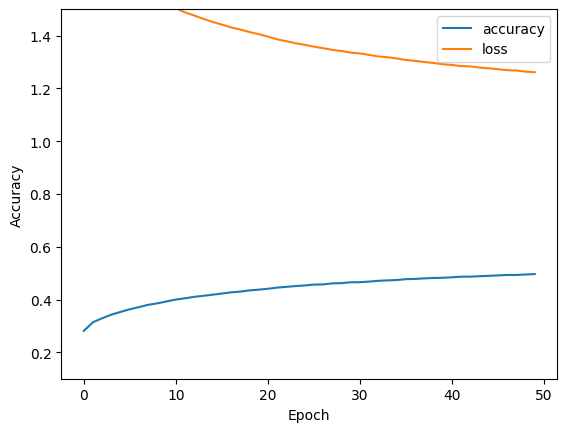

In [ ]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['loss'], label = 'loss')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.1, 1.5])
plt.legend(loc='upper right')

test_loss, test_acc = model.evaluate(x_test, y_test, verbose=1)